In [1]:
!tree ../dataset

../dataset
├── en_espanol
│   ├── docx2txt.py
│   ├── Второй_жанр_исходная.txt
│   └── Первый_жанр_исходная.txt
├── Второй_жанр_исходная.txt
├── Первый_жанр_исходная.txt
├── Сокращение по частям речи
│   ├── 1.Первый жанр исходная выборка.txt
│   ├── 2.Первый жанр без клауз, включающих наречия.txt
│   ├── 3.Первый жанр без клауз, включающих глаголы.txt
│   ├── 4.Первый жанр без клауз, включающих глаголы и наречия.txt
│   ├── Без прилагательных второй жанр.txt
│   ├── Без прилагательных первый жанр.txt
│   └── Случайные выборки.txt
└── сокращение по частотности
    ├── 1а_ без сокращений.txt
    ├── 1б_Изъяты лексемы с частотой выше 100.txt
    ├── 1в_Изъяты лексемы с частотой выше 49.txt
    ├── 1г_Изъяты лексемы с частотой выше 29.txt
    ├── 1д_Изъяты лексемы с частотой выше 9.txt
    ├── 1е_Изъяты лексемы с частотой выше 5.txt
    ├── 1ё_Изъяты лексемы с частотой выше 3.txt
    ├── 2а_ без сокращений.txt
    ├── 2б_Изъяты лексемы с частотой выше 100.txt
    ├── 2в_Изъяты лексемы с ч

In [2]:
ls

 __pycache__/            parte_2_Step1.png
 frecuencia_step_1.png   utils.py
 funciones.py           'Сокращение по частям речи'/
 generador.ipynb        'сокращение по частотности'/
 herramientas.ipynb     'сокращение по частотности.ipynb'


2025-04-07 06:04:45.371031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


train_Изъяты лексемы с частотой выше 100 - rubert-base.csv
test_Изъяты лексемы с частотой выше 100 - rubert-base.csv
train_Изъяты лексемы с частотой выше 49 - rubert-base.csv
test_Изъяты лексемы с частотой выше 49 - rubert-base.csv
train_Изъяты лексемы с частотой выше 29 - rubert-base.csv
test_Изъяты лексемы с частотой выше 29 - rubert-base.csv
train_Изъяты лексемы с частотой выше 9 - rubert-base.csv
test_Изъяты лексемы с частотой выше 9 - rubert-base.csv
train_Изъяты лексемы с частотой выше 5 - rubert-base.csv
test_Изъяты лексемы с частотой выше 5 - rubert-base.csv
train_Изъяты лексемы с частотой выше 3 - rubert-base.csv
test_Изъяты лексемы с частотой выше 3 - rubert-base.csv
train_Изъяты лексемы с частотой выше 100 - BERT multilingual.csv
test_Изъяты лексемы с частотой выше 100 - BERT multilingual.csv
train_Изъяты лексемы с частотой выше 49 - BERT multilingual.csv
test_Изъяты лексемы с частотой выше 49 - BERT multilingual.csv
train_Изъяты лексемы с частотой выше 29 - BERT multilingua

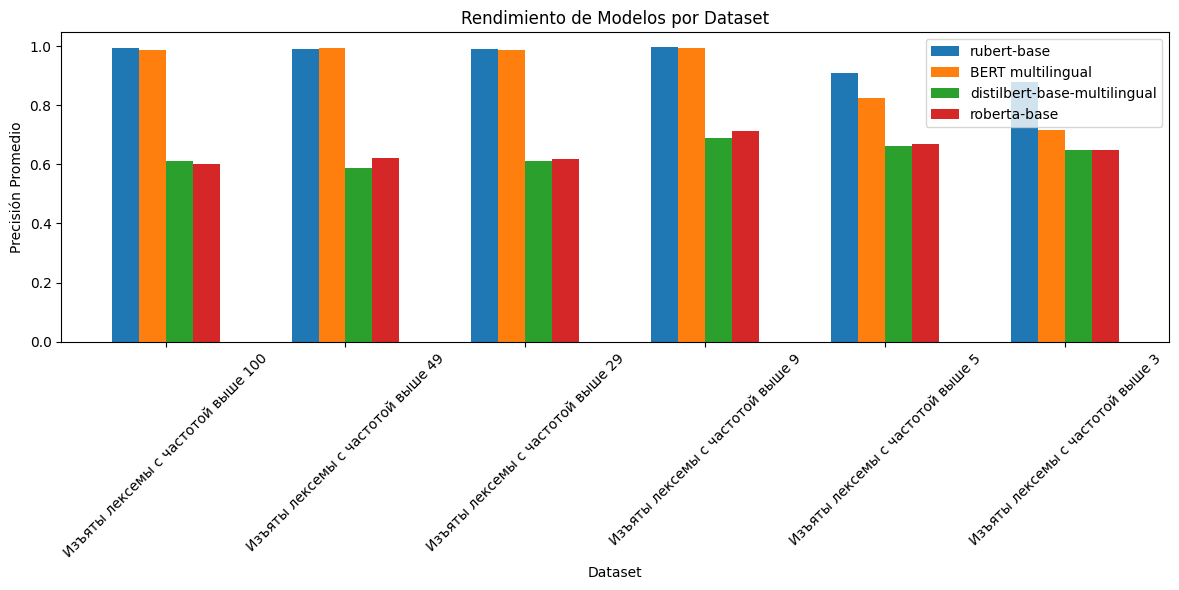

In [3]:
#     ├── 1а_ без сокращений.txt
#     ├── 1б_Изъяты лексемы с частотой выше 100.txt
#     ├── 1в_Изъяты лексемы с частотой выше 49.txt
#     ├── 1г_Изъяты лексемы с частотой выше 29.txt
#     ├── 1д_Изъяты лексемы с частотой выше 9.txt
#     ├── 1е_Изъяты лексемы с частотой выше 5.txt
#     ├── 1ё_Изъяты лексемы с частотой выше 3.txt
#     ├── 2а_ без сокращений.txt
#     ├── 2б_Изъяты лексемы с частотой выше 100.txt
#     ├── 2в_Изъяты лексемы с частотой выше 49.txt
#     ├── 2г_Изъяты лексемы с частотой выше 29.txt
#     ├── 2д_Изъяты лексемы с частотой выше 9.txt
#     ├── 2е_Изъяты лексемы с частотой выше 5.txt
#     └── 2ё_Изъяты лексемы с частотой выше 3.txt
import funciones
from utils import train_wrapper
import warnings
import os
import torch
import matplotlib.pyplot as plt

# Suprimir warnings específicos
warnings.filterwarnings('ignore', category=UserWarning)  # Para sklearn y otros
warnings.filterwarnings('ignore', category=FutureWarning)  # Para huggingface y transformers
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from contextlib import redirect_stderr
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import numpy as np
mp.set_start_method('spawn', force=True)
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
def train_wrapper(args):
    dataset, config = args  # Desempaquetar los argumentos
    return funciones.train_and_evaluate_dataset(
        dataset['path1'],
        dataset['path2'],
        config,
        dataset['name']
    )
def create_custom_config(freq_threshold_dataset, model_name):
    base_config = {
        'model_name': model_name,
        'num_repeats': 6,
        'test_size': 0.2,
        'threshold': 0.5
    }
    
    # Configuraciones específicas por dataset
    if freq_threshold_dataset == 100:
        return funciones.TrainingConfig(
            **base_config,
            max_length=52,      # Longitud estándar
            batch_size=128,       # Reducido para ahorrar memoria
            epochs=3,            # Menos épocas, dataset más simple
            learning_rate=2e-5   # LR estándar
        )
    elif freq_threshold_dataset == 49:
        return funciones.TrainingConfig(
            **base_config,
            max_length=60,
            batch_size=128,       # Ligeramente menor
            epochs=4,            # Más épocas para mayor complejidad
            learning_rate=3e-5   # LR un poco más alto
        )
    elif freq_threshold_dataset == 29:
        return funciones.TrainingConfig(
            **base_config,
            max_length=51,
            batch_size=128,       # Reducción adicional
            epochs=4,
            learning_rate=3e-5
        )
    elif freq_threshold_dataset == 9:
        return funciones.TrainingConfig(
            **base_config,
            max_length=45,       # Reducido para datasets más complejos
            batch_size=128,        # Más pequeño
            epochs=5,            # Más épocas
            learning_rate=4e-5   # LR más agresivo
        )
    elif freq_threshold_dataset == 5:
        return funciones.TrainingConfig(
            **base_config,
            max_length=150,       # Reducido en lugar de 256
            batch_size=128,        # Muy pequeño para ahorrar memoria
            epochs=6,            # Más épocas
            learning_rate=5e-5   # LR más alto
        )
    elif freq_threshold_dataset == 3:
        return funciones.TrainingConfig(
            **base_config,
            max_length=150,       # Reducido en lugar de 256
            batch_size=128,        #
            epochs=6,
            learning_rate=5e-5
        )


    
def main():
    models = [
            {'model':'DeepPavlov/rubert-base-cased', 'name':'rubert-base'},      # Modelo original
            {'model':'bert-base-multilingual-cased', 'name':'BERT multilingual' },      # BERT multilingüe
            {'model':'distilbert-base-multilingual-cased', 'name':'distilbert-base-multilingual'},# Versión ligera de BERT
            {'model':'roberta-base', 'name':'roberta-base'},                      # RoBERTa 
        ]
    datasets = [
            {
                'path1': '../dataset/сокращение по частотности/1б_Изъяты лексемы с частотой выше 100.txt',
                'path2': '../dataset/сокращение по частотности/2б_Изъяты лексемы с частотой выше 100.txt',
                'name': 'Изъяты лексемы с частотой выше 100',
                'freq': 100
            },
            {
                'path1': '../dataset/сокращение по частотности/1в_Изъяты лексемы с частотой выше 49.txt',
                'path2': '../dataset/сокращение по частотности/2в_Изъяты лексемы с частотой выше 49.txt',
                'name': 'Изъяты лексемы с частотой выше 49',
                'freq': 49
            },
            {
                'path1': '../dataset/сокращение по частотности/1г_Изъяты лексемы с частотой выше 29.txt',
                'path2': '../dataset/сокращение по частотности/2г_Изъяты лексемы с частотой выше 29.txt',
                'name': 'Изъяты лексемы с частотой выше 29',
                'freq': 29
            },
            {
                'path1': '../dataset/сокращение по частотности/1д_Изъяты лексемы с частотой выше 9.txt',
                'path2': '../dataset/сокращение по частотности/2д_Изъяты лексемы с частотой выше 9.txt',
                'name': 'Изъяты лексемы с частотой выше 9',
                'freq': 9
            },
            {
                'path1': '../dataset/сокращение по частотности/1е_Изъяты лексемы с частотой выше 5.txt',
                'path2': '../dataset/сокращение по частотности/2е_Изъяты лексемы с частотой выше 5.txt',
                'name': 'Изъяты лексемы с частотой выше 5',
                'freq': 5
            },
            {
                'path1': '../dataset/сокращение по частотности/1ё_Изъяты лексемы с частотой выше 3.txt',
                'path2': '../dataset/сокращение по частотности/2ё_Изъяты лексемы с частотой выше 3.txt',
                'name': 'Изъяты лексемы с частотой выше 3',
                'freq': 3
            },
        ]


    
 
    
    results = []
    for model_idx, model in enumerate(models):
        for dataset in datasets:
            # Crear nombre único para esta combinación
            dataset_copy = dataset.copy()
            dataset_copy['name'] = f"{dataset['name']} - {model['name']}"
            config = create_custom_config(dataset['freq'], model['model'])
            args = (dataset_copy, config)
            
            # Entrenar y limpiar memoria
            torch.cuda.empty_cache()
            result = train_wrapper(args)
            results.append(result)

    torch.cuda.empty_cache()        
    # Mostrar resumen
    print("\n Resultados de todos los experimentos:")
    for result in results:
        print(f"{result['dataset_name']}: "
              f"{result['avg_accuracy']:.4f} ± {result['std_accuracy']:.4f}")

    # Preparar datos para el gráfico
    dataset_names = [d['name'] for d in datasets]  # Nombres base de datasets
    model_names = [f"{i['name']}" for _, i in enumerate(models)] # Nombres de modelos como en results

    # Matriz de accuracies
    accuracies = np.zeros((len(dataset_names), len(model_names)))

    for i, dataset_name in enumerate(dataset_names):
        for j, model_name in enumerate(model_names):
            for result in results:
                if dataset_name in result['dataset_name'] and model_name in result['dataset_name']:
                    accuracies[i, j] = result['avg_accuracy']
                    break # Importante: salir del bucle interno una vez encontrada la precisión

    # Graficar
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.15
    index = np.arange(len(dataset_names))

    for i, model_name in enumerate(model_names):
        plt.bar(index + i * bar_width, accuracies[:, i], bar_width, label=model_name)

    plt.xlabel('Dataset')
    plt.ylabel('Precisión Promedio')
    plt.title('Rendimiento de Modelos por Dataset')
    plt.xticks(index + bar_width * (len(model_names) - 1) / 2, dataset_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('frecuencia.png') # Guarda la figura como un archivo PNG

    plt.show()

        
if __name__ == "__main__":
    main()

In [4]:
# import os
# import IPython

# # Reiniciar el kernel
# IPython.display.display(IPython.display.Javascript("Jupyter.notebook.kernel.restart()"))

# # Apagar el kernel después de reiniciar
# os._exit(0)

In [5]:
#batch_size=128v

In [6]:
import funciones
from utils import train_wrapper
import warnings
import os
import torch
import matplotlib.pyplot as plt

# Suprimir warnings específicos
warnings.filterwarnings('ignore', category=UserWarning)  # Para sklearn y otros
warnings.filterwarnings('ignore', category=FutureWarning)  # Para huggingface y transformers
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from contextlib import redirect_stderr
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import numpy as np
mp.set_start_method('spawn', force=True)
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
def train_wrapper(args):
    dataset, config = args  # Desempaquetar los argumentos
    return funciones.train_and_evaluate_dataset(
        dataset['path1'],
        dataset['path2'],
        config,
        dataset['name']
    )
def create_custom_config_2(name_dataset, model_name):
    base_config = {
        'model_name': model_name,
        'num_repeats': 6,
        'test_size': 0.2,
        'threshold': 0.5
    }
    
    # Configuraciones específicas por dataset
    if "1" in name_dataset:
        return funciones.TrainingConfig(
            **base_config,
            max_length=60,      # Longitud estándar
            batch_size=128,       # Reducido para ahorrar memoria
            epochs=6,            # Menos épocas, dataset más simple
            learning_rate=5e-5   # LR estándar
        )
    elif "2" in name_dataset:
        return funciones.TrainingConfig(
            **base_config,
            max_length=60,
            batch_size=128,       # Ligeramente menor
            epochs=6,            # Más épocas para mayor complejidad
            learning_rate=5e-5   # LR un poco más alto
        )
    elif "3" in name_dataset:
        return funciones.TrainingConfig(
            **base_config,
            max_length=60,
            batch_size=128,       # Reducción adicional
            epochs=6,
            learning_rate=5e-5
        )
    elif "4" in name_dataset:
        return funciones.TrainingConfig(
            **base_config,
            max_length=60,       # Reducido para datasets más complejos
            batch_size=128,        # Más pequeño
            epochs=6,            # Más épocas
            learning_rate=5e-5   # LR más agresivo
        )



    

In [7]:
### ahora usar el mismo modelo para entrenar por perdida de vebos

# ├── Сокращение по частям речи
# │   ├── 1.Первый жанр исходная выборка.txt
# │   ├── 2.Первый жанр без клауз, включающих наречия.txt
# │   ├── 3.Первый жанр без клауз, включающих глаголы.txt
# │   ├── 4.Первый жанр без клауз, включающих глаголы и наречия.txt
# │   ├── Без прилагательных второй жанр.txt
# │   ├── Без прилагательных первый жанр.txt
# │   └── Случайные выборки.txt

In [8]:
models = [
        {'model':'DeepPavlov/rubert-base-cased', 'name':'rubert-base'},      # Modelo original
        {'model':'bert-base-multilingual-cased', 'name':'BERT multilingual' },      # BERT multilingüe
        {'model':'distilbert-base-multilingual-cased', 'name':'distilbert-base-multilingual'},# Versión ligera de BERT
        {'model':'roberta-base', 'name':'roberta-base'},                      # RoBERTa 
    ]

datasets = [
        {
            'path1': '../dataset/Сокращение по частям речи/1.Первый жанр исходная выборка.txt',
            'path2': '../dataset/Второй_жанр_исходная.txt',
            'name': '1.Первый жанр исходная выборка',

        },
        {
            'path1': '../dataset/Сокращение по частям речи/2.Первый жанр без клауз, включающих наречия.txt',
            'path2': '../dataset/Второй_жанр_исходная.txt',
            'name': '2.Первый жанр без клауз, включающих наречия',
        },
        {
            'path1': '../dataset/Сокращение по частям речи/3.Первый жанр без клауз, включающих глаголы.txt',
            'path2': '../dataset/Второй_жанр_исходная.txt',
            'name': '3.Первый жанр без клауз, включающих глаголы',
        },
        {
            'path1': '../dataset/Сокращение по частям речи/4.Первый жанр без клауз, включающих глаголы и наречия.txt',
            'path2': '../dataset/Второй_жанр_исходная.txt',
            'name': '4.Первый жанр без клауз, включающих глаголы и наречия',
        },

    ]


train_1.Первый жанр исходная выборка - rubert-base.csv
test_1.Первый жанр исходная выборка - rubert-base.csv
train_2.Первый жанр без клауз, включающих наречия - rubert-base.csv
test_2.Первый жанр без клауз, включающих наречия - rubert-base.csv
train_3.Первый жанр без клауз, включающих глаголы - rubert-base.csv
test_3.Первый жанр без клауз, включающих глаголы - rubert-base.csv
train_4.Первый жанр без клауз, включающих глаголы и наречия - rubert-base.csv
test_4.Первый жанр без клауз, включающих глаголы и наречия - rubert-base.csv
train_1.Первый жанр исходная выборка - BERT multilingual.csv
test_1.Первый жанр исходная выборка - BERT multilingual.csv
train_2.Первый жанр без клауз, включающих наречия - BERT multilingual.csv
test_2.Первый жанр без клауз, включающих наречия - BERT multilingual.csv
train_3.Первый жанр без клауз, включающих глаголы - BERT multilingual.csv
test_3.Первый жанр без клауз, включающих глаголы - BERT multilingual.csv
train_4.Первый жанр без клауз, включающих глаголы и

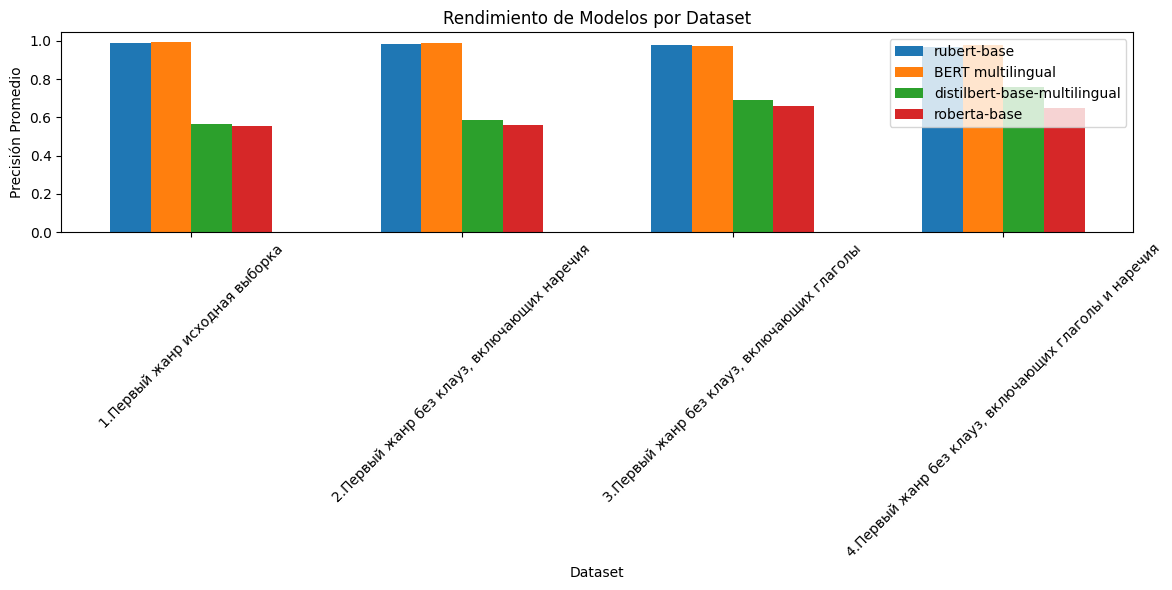

In [9]:
results = []
for model_idx, model in enumerate(models):
    for dataset in datasets:
            # Crear nombre único para esta combinación
        dataset_copy = dataset.copy()
        dataset_copy['name'] = f"{dataset['name']} - {model['name']}"
        config = create_custom_config_2(dataset['name'], model['model'])
        args = (dataset_copy, config)
            
            # Entrenar y limpiar memoria
        torch.cuda.empty_cache()
        result = train_wrapper(args)
        results.append(result)

torch.cuda.empty_cache()        
    # Mostrar resumen
print("\n Resultados de todos los experimentos:")
for result in results:
    print(f"{result['dataset_name']}: "
            f"{result['avg_accuracy']:.4f} ± {result['std_accuracy']:.4f}")

    # Preparar datos para el gráfico
dataset_names = [d['name'] for d in datasets]  # Nombres base de datasets
model_names = [f"{i['name']}" for _,i in enumerate(models)] # Nombres de modelos como en results

# Matriz de accuracies
accuracies = np.zeros((len(dataset_names), len(model_names)))

for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        for result in results:
            if dataset_name in result['dataset_name'] and model_name in result['dataset_name']:
                accuracies[i, j] = result['avg_accuracy']
                break # Importante: salir del bucle interno una vez encontrada la precisión

# Graficar
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(dataset_names))

for i, model_name in enumerate(model_names):
    plt.bar(index + i * bar_width, accuracies[:, i], bar_width, label=model_name)

plt.xlabel('Dataset')
plt.ylabel('Precisión Promedio')
plt.title('Rendimiento de Modelos por Dataset')
plt.xticks(index + bar_width * (len(model_names) - 1) / 2, dataset_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('parte_2.png') # Guarda la figura como un archivo PNG

plt.show()


In [10]:
#funciones.display_results(results, dataset, models)

In [11]:
#from funciones import display_results


In [12]:
#display_results()

In [ ]:
import os
import IPython

# Reiniciar el kernel
IPython.display.display(IPython.display.Javascript("Jupyter.notebook.kernel.restart()"))

# Apagar el kernel después de reiniciar
os._exit(0)